# Learn from materials data - part A
Training and test data come from the same distributions.

## Get the data and look at distributions of inputs / outputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import *
%run Data_Abaqus_v3/Scripts/utility_functions

In [2]:
n_inputs = 4
input_names = ['$vf$', '$E_f$ (GPa)', '$b_{m}$ (MPa)', '$c_{m}$']
n_outputs = 5
output_names = ['$b_{eff}$ (MPa)', '$c_{eff}$', '$E_{eff}$ (GPa)', r'$\nu_{eff}$', '$p_{0.9 GPa}$ (%)']
a_fixed = 400.
name_ext = '_bis_a[400].pkl'

In [3]:
bounds_inputs = np.array([(0.05, 0.4), (200, 600), (300, 500), (0.2, 0.55)])
bounds_outputs = np.array([(300., 800.), (0.16, 0.5), (100., 170.), (0.277, 0.299), (0., 0.8)])
mean_outputs = np.mean(bounds_outputs, axis=-1)
coeff_var_outputs = np.array([0.03, 0.02, 0.005, 0.002, 0.25])
std_outputs = mean_outputs * coeff_var_outputs

type_norm = '[-1,1]'

#cov_aleatoric = np.array([[ 4.4e+01,  1.6e+00,  7.0e-02, -3.4e-01, 1.2e-04, -2.7e-02],
#                          [ 1.6e+00,  8.4e+01,  1.3e-02,  2.8e+00, -2.4e-03,  4.1e-01],
#                          [ 7.0e-02,  1.3e-02,  1.2e-04, -9.9e-05, -6.8e-08,  -1.7e-05],
#                          [-3.4e-01,  2.8e+00, -9.8e-05,  1.8e-01, -9.8e-05,  1.3e-02],
#                          [ 1.2e-04, -2.4e-03, -6.8e-08, -9.8e-05, 1.0e-07, -1.3e-05],
#                          [-2.7e-02,  4.1e-01,  -1.7e-05,  1.3e-02, -1.3e-05,  3.6e-03]])
#cov_aleatoric = np.array([[ 5e+01,  0.,  1e-1, 0., 0., 0.],
#                          [ 0.,  10e+01,  0.,  3e+00, -3e-03,  5e-01],
#                          [ 1e-1,  0.,  2e-04, 0., 0.,  0.],
#                          [0.,  3e+00, 0.,  2e-01, -10e-05,  2e-02],
#                          [ 0., -3e-03, 0., -10e-05, 1.5e-07, -2e-05],
#                          [0.,  5e-01,  0.,  2e-02, -2e-05,  5e-03]])
cov_aleatoric = np.diag(std_outputs ** 2)
cov_aleatoric_norm = normalize_covariance_from_bounds(cov_aleatoric, bounds_outputs, type_norm=type_norm)
print(cov_aleatoric_norm)

[[0.004356   0.         0.         0.         0.        ]
 [0.         0.00150727 0.         0.         0.        ]
 [0.         0.         0.00037194 0.         0.        ]
 [0.         0.         0.         0.00274195 0.        ]
 [0.         0.         0.         0.         0.0625    ]]


### Get the data

In [4]:
with open('Data_Abaqus_v3/training_random' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_train, y_train = d['inpts'], d['outpts']
    print('Shape of training data: {}'.format(x_train.shape[0]))
x_train_norm = normalize_from_bounds(x_train, bounds_inputs, type_norm=type_norm)
y_train_norm = normalize_from_bounds(y_train, bounds_outputs, type_norm=type_norm)

Shape of training data: 100


In [5]:
with open('Data_Abaqus_v3/testing_random' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_test, y_test = d['inpts'], d['outpts']
    print('Shape of test data: {}'.format(x_test.shape[0]))
x_test_norm = normalize_from_bounds(x_test, bounds_inputs, type_norm=type_norm)
y_test_norm = normalize_from_bounds(y_test, bounds_outputs, type_norm=type_norm)

Shape of test data: 50


Distribution of inputs


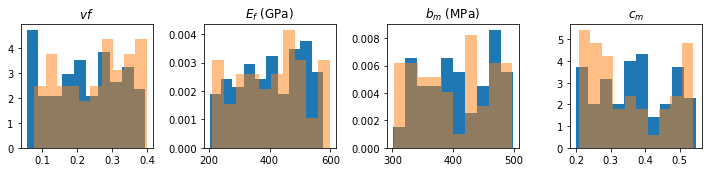

Distribution of outputs


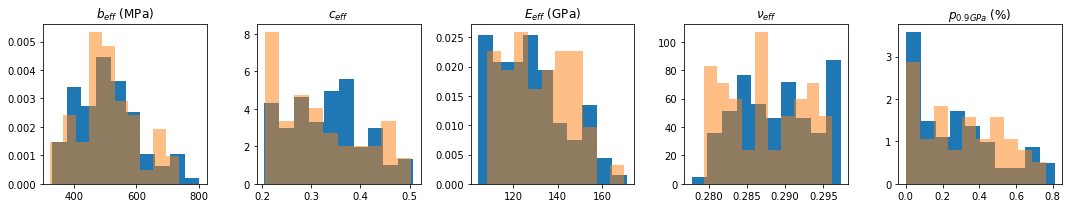

In [6]:
print('Distribution of inputs')
fig, ax = plt.subplots(ncols=4, figsize=(4 * 2.5, 2.5))
for i in range(4):
    ax[i].hist(x_train[:, i], density=True)
    ax[i].hist(x_test[:, i], density=True, alpha=0.5)
    ax[i].set_title(input_names[i])
plt.tight_layout()
plt.show(fig)

print('Distribution of outputs')
fig, ax = plt.subplots(ncols=5, figsize=(5 * 3, 3))
for i in range(5):
    ax[i].hist(y_train[:, i], density=True)
    ax[i].hist(y_test[:, i], density=True, alpha=0.5)
    ax[i].set_title(output_names[i])
plt.tight_layout()
plt.show(fig)

## Setup the network and necessary functions

In [7]:
nn_kwargs = {'var_n': cov_aleatoric_norm,
             'output_dim': n_outputs,
             'input_dim': n_inputs,
             'hidden_units': (20, 20, 20),
             'activation': tf.nn.relu,
             'prior_means': 0.,
             'prior_stds': 1.}

weights_to_track = [4, 2, 4, 2, 4, 2, 4, 2]
nw = np.sum(weights_to_track)
n_layers = len(weights_to_track)//2
nw_per_layer = [weights_to_track[2*l] + weights_to_track[2*l+1] for l in range(n_layers)]
cumsum_nw_per_layer = np.cumsum([0] + nw_per_layer)

colors_layers = ['green', 'blue', 'red', 'orange', 'magenta', 'yellow', 'cyan']
markers_layers = ['o', '+', 'x', 'd', 's', 'o', '+']

(25, 200, 5)


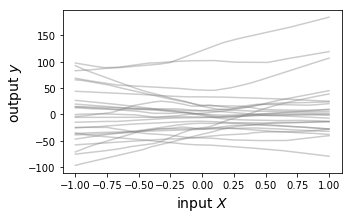

In [8]:
X_test = np.concatenate([np.linspace(-1., 1., 200).reshape((200, 1)), np.zeros((200, 3))], axis=1)

fig, ax = plt.subplots(figsize=(5, 3))
reg = Regressor(**nn_kwargs)
y_MC = reg.predict_uq_from_prior(X=X_test, ns=25)
print(y_MC.shape)
plot_mean_MC(np.linspace(-1., 1., 200), y_MC[:, :, 0], ax)
plt.show()

In [9]:
def plot_loss(reg, epoch_start=500):
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(reg.loss_history[:])
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel('loss')
    ax[1].plot(reg.loss_history[epoch_start:])
    ax[1].set_xlabel('epoch {} onwards'.format(epoch_start)); ax[1].set_ylabel('loss')
    plt.show(fig)
    return fig, ax

def plot_convergence_weights(reg):
    weights_mean = reg.variational_mu_history 
    weights_std = reg.variational_sigma_history
    fig, ax = plt.subplots(figsize=(13,  3.5), ncols=2)
    for l, (means, stds) in enumerate(zip(weights_mean[:-1], weights_std[:-1])):
        for j, (w_mean, w_std) in enumerate(zip(means.T, stds.T)):
            alpha = 0.15+j*0.8/weights_to_track[l]
            ax[0].plot(w_mean, color=colors_layers[l], alpha=alpha)
            ax[1].plot(w_std, color=colors_layers[l], alpha=alpha)
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel(r'$\mu$'); 
    ax[0].set_title(r'Convergence of means $\mu_{i}$')
    ax[1].set_xlabel('epochs'); ax[1].set_ylabel(r'$\sigma$'); 
    ax[1].set_title(r'Convergence of std. devs. $\sigma_{i}$')
    return fig, ax

def plot_ystd(ytest, ypred, ystd, outputs=(0, 1, 2, 3, 4)):
    fig, ax = plt.subplots(ncols=5, figsize=(18, 3.))
    for i, (y_true, y_pm, y_ps) in enumerate(zip(ytest.T, ypred.T, ystd.T)):
        bds_i = bounds_outputs[i]
        ax[i].plot([-1.05, 1.05], [-1.05, 1.05], color='gray', linestyle='--')
        ax[i].errorbar(x=y_true, y=y_pm, yerr=y_ps, xerr=y_ps, color='red', linestyle='none', 
                           label='aleatoric uncertainty')
        ax[i].set_xticks([-1, 0, 1])
        ax[i].set_xticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
        ax[i].set_xlabel('$y_{true}$', fontsize=13)
        ax[i].set_yticks([-1, 0, 1])
        ax[i].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
        if i == 0:
            ax[i].set_ylabel('$y_{predicted}$', fontsize=13)
        ax[i].set_title(output_names[i], fontsize=16)
        ax[i].axis('equal')
    fig.tight_layout()
    return fig, ax

colors_data = ['purple', 'orange', 'green', 'blue']
def plot_law_MC(ytest, yMC, indices_test, yMCaleatoric=None):
    fig, ax = plt.subplots(ncols=len(indices_test), figsize=(15, 3.))
    domain = np.linspace(0.0, 0.05, 100)
    for n, (i, c) in enumerate(zip(indices_test, colors_data)):
        percentiles_total = np.zeros((len(domain), 2))
        percentiles_aleatoric = np.zeros((len(domain), 2))
        for d_, d in enumerate(domain):
            law_MC = a_fixed + yMC[:, i, 0] * d ** yMC[:, i, 1]
            percentiles_total[d_, :] = np.percentile(law_MC, [2.5, 97.5])
            if yMCaleatoric is not None:
                law_MC = a_fixed + yMCaleatoric[:, i, 0] * d ** yMCaleatoric[:, i, 1]
                percentiles_aleatoric[d_, :] = np.percentile(law_MC, [2.5, 97.5])
        if yMCaleatoric is None:
            alpha = 0.3
        else:
            alpha = 0.15
        ax[n].fill_between(domain, percentiles_total[:, 0], percentiles_total[:, 1],
                           color=c, alpha=alpha, label='epistemic uncertainty')
        if yMCaleatoric is not None:
            ax[n].fill_between(domain, percentiles_aleatoric[:, 0], percentiles_aleatoric[:, 1],
                               color=c, alpha=0.7, label='aleatoric uncertainty')
        #for y_ in yMC:
        #    ax[n].plot(domain, y_[i, 0]+y_[i, 1]*domain**y_[i, 2], color=c, alpha=0.05)
        ax[n].plot(domain, a_fixed + ytest[i, 0] * domain ** ytest[i, 1], color='black')
        ax[n].set_xlabel(r'plastic strain $\varepsilon_{p}$', fontsize=12)
        ax[n].set_ylabel(r'stress $\sigma$ (MPa)', fontsize=12)
        ax[n].set_ylim([400, 750])
        ax[n].set_yticks([400, 500, 600, 700])
        ax[n].set_xticks([0., 0.025, 0.05])
    fig.tight_layout()
    return fig, ax

## Study with the BayesByBackprop vs alphaBB algorithm

### Train a network to predict output with large amounts of data

In [10]:
regBBa_100 = alphaBB(alpha=0.1, weights_to_track=weights_to_track, **nn_kwargs)

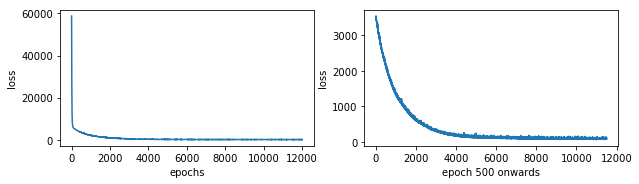

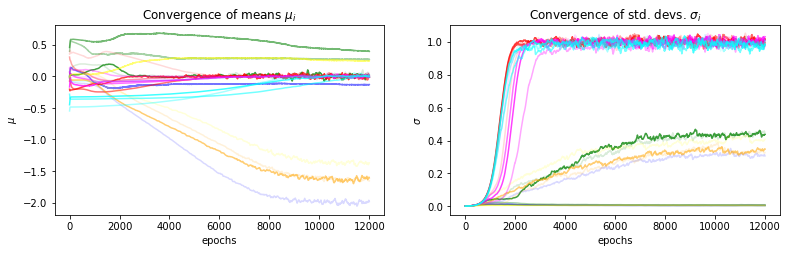

In [11]:
regBBa_100.fit(X=x_train_norm, y=y_train_norm, ns=20, verbose=False, epochs=12000, lr=0.005)

fig, ax = plot_loss(regBBa_100)
plt.show(fig)
fig, ax = plot_convergence_weights(regBBa_100)
plt.show(fig)

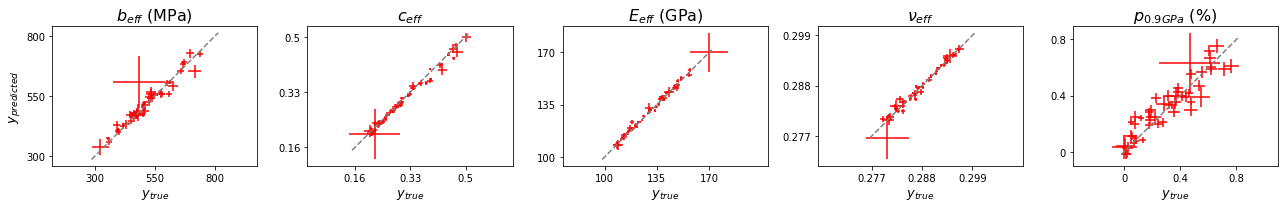

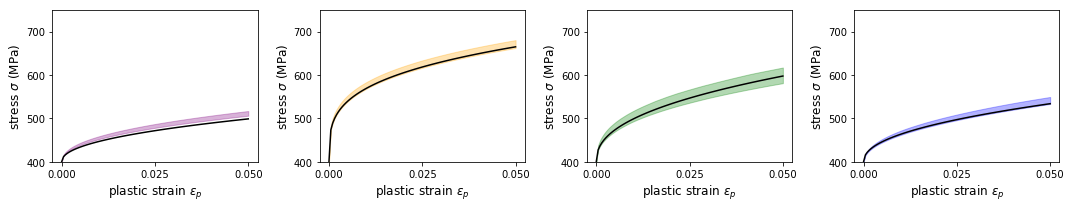

In [12]:
ypred, ystd, yMC = regBBa_100.predict_uq(X=x_test_norm, ns=10000, return_std=True, return_percentiles=(), 
                                        return_MC=5000, aleatoric_in_std_perc=False, aleatoric_in_MC=False)

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
#fig.tight_layout()
#fig.savefig('PartA_100_crosses.pdf')
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
#fig.savefig('PartA_100_laws.pdf')
plt.show(fig)

### Try with BayesByBackprop

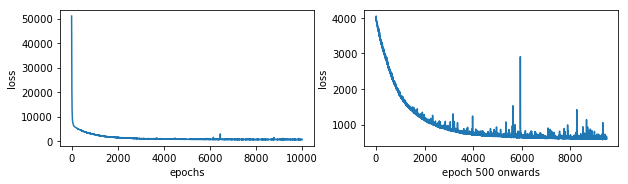

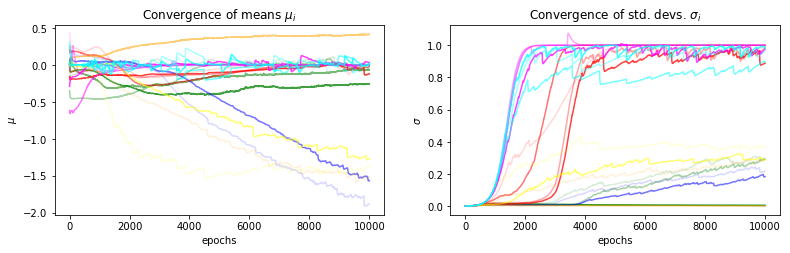

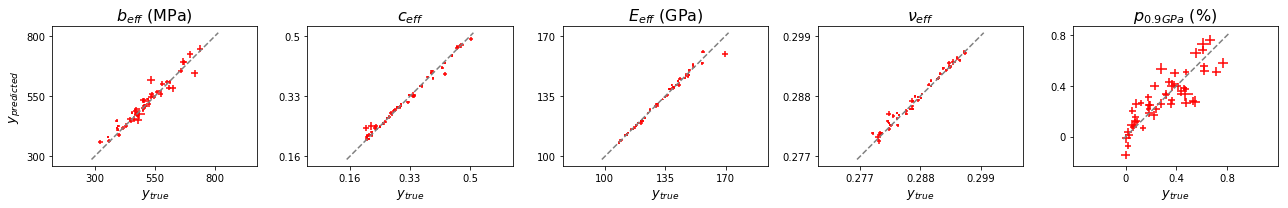

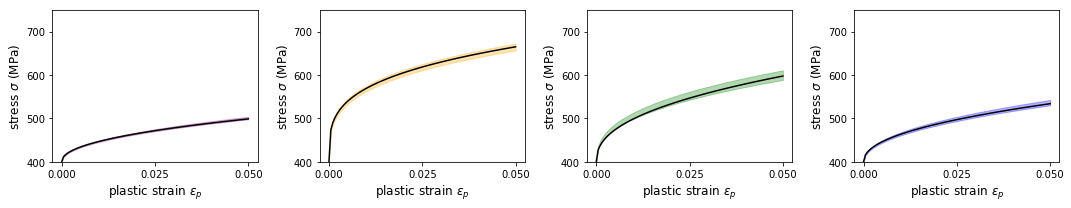

In [13]:
regBB_100 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn_kwargs)

regBB_100.fit(X=x_train_norm, y=y_train_norm, ns=20, verbose=False, epochs=10000, lr=0.005)

fig, ax = plot_loss(regBB_100)
plt.show(fig)
fig, ax = plot_convergence_weights(regBB_100)
plt.show(fig)

ypred, ystd, yMC = regBB_100.predict_uq(X=x_test_norm, ns=12000, return_std=True, return_percentiles=(), 
                                     return_MC=5000, aleatoric_in_std_perc=False, aleatoric_in_MC=False)

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
#fig.tight_layout()
#fig.savefig('PartA_100_crosses.pdf')
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
#fig.savefig('PartA_100_laws.pdf')
plt.show(fig)

### Combine various algorithms

In [14]:
alpha_list = [0, 0.05, 0.1, 0.15, 0.2]
#random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)
random_seed_list = [5324, ] * len(alpha_list)

model_aving = ModelAveragingLOOalphaBB(
    nn_dict=nn_kwargs, training_data=(x_train_norm, y_train_norm), 
    training_dict={'ns': 20, 'epochs': 12000, 'lr': 0.005},
    n_bootstrap=100, alpha_list=alpha_list, random_seed_list=random_seed_list)

print(model_aving.weights_elpd)
print(model_aving.weights_modified_elpd)
print(model_aving.weights_elpd_bb)

Adding model with alpha=0.0001
Adding model with alpha=0.05
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
[6.3995969e-01 3.6003810e-01 1.8126206e-05 2.1740765e-07 2.9541493e-06]
[7.20431166e-01 2.79557021e-01 8.36363050e-06 1.10584454e-07
 3.33917357e-06]
[6.08892495e-01 3.84489368e-01 5.41829134e-03 1.85786763e-05
 1.18126700e-03]


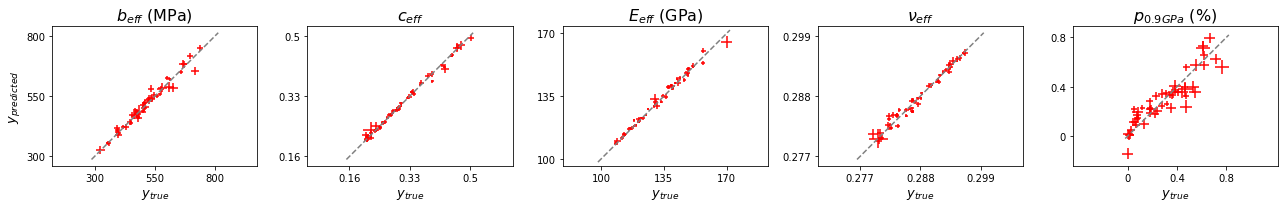

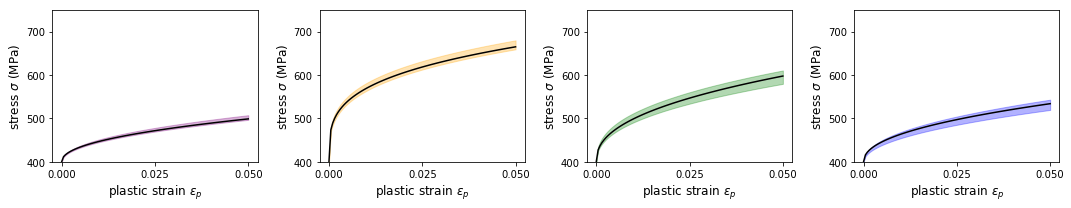

In [41]:
ypred, ystd, yMC = model_aving.predict_uq(
    X=x_test_norm, ns=10000, return_std=True, return_percentiles=(), aleatoric_in_std_perc=False, 
    aleatoric_in_MC=False, return_MC=5000) 

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
#fig.tight_layout()
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
plt.show(fig)

Adding model with alpha=0.040036037476602886
Adding model with alpha=0.03390341117802026
Adding model with alpha=0.04452320627285783
Adding model with alpha=0.0877544981034649
Adding model with alpha=0.014738909089944952
Adding model with alpha=0.033751137986747205
Adding model with alpha=0.02085303856074271
Adding model with alpha=0.02366075781407283
Adding model with alpha=0.06998721892728584
Adding model with alpha=0.09005472581911944
[3.9929383e-11 3.7133830e-07 9.3722365e-06 7.9205811e-02 9.2040014e-01
 1.3384831e-10 6.5038566e-06 5.6370607e-07 3.5808026e-04 8.9613849e-07]
[9.46822019e-12 1.77642206e-07 3.76066683e-06 6.68652643e-02
 9.32933409e-01 3.01814629e-11 2.43171357e-06 1.58653588e-07
 1.94420293e-04 3.77808057e-07]
[1.96838545e-07 9.08784035e-05 7.90187356e-03 2.96966208e-01
 6.50460739e-01 1.51338562e-07 9.88809377e-03 2.61142883e-03
 3.19422068e-02 1.38223254e-04]


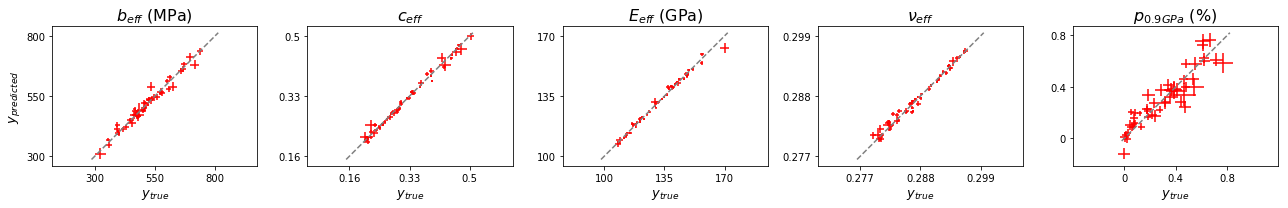

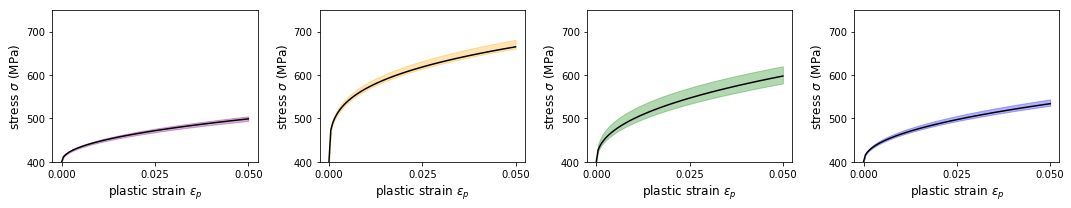

In [21]:
alpha_list = 0.1 * np.random.rand(10)
random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)

model_aving_2 = ModelAveragingLOOalphaBB(
    nn_dict=nn_kwargs, training_data=(x_train_norm, y_train_norm), 
    training_dict={'ns': 20, 'epochs': 12000, 'lr': 0.005},
    n_bootstrap=100, alpha_list=alpha_list, random_seed_list=random_seed_list)

print(model_aving_2.weights_elpd)
print(model_aving_2.weights_modified_elpd)
print(model_aving_2.weights_elpd_bb)

ypred, ystd, yMC = model_aving_2.predict_uq(
    X=x_test_norm, ns=10000, return_std=True, return_percentiles=(), aleatoric_in_std_perc=False, 
    aleatoric_in_MC=False, return_MC=5000) 

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
#fig.tight_layout()
#fig.savefig('PartA_100_crosses.pdf')
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
#fig.savefig('PartA_100_laws.pdf')
plt.show(fig)

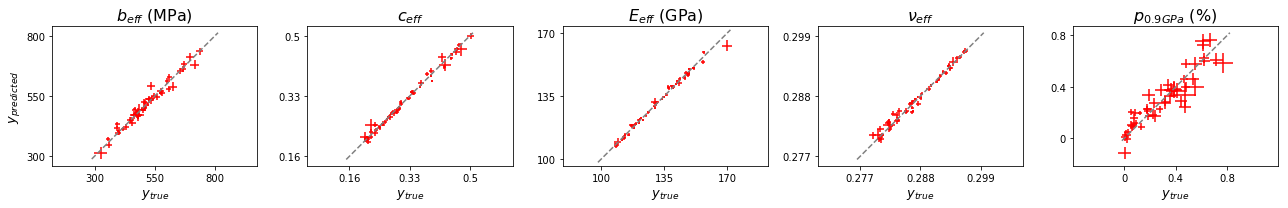

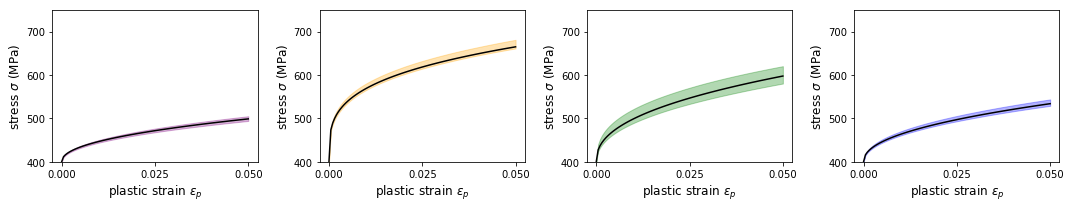

In [42]:
ypred, ystd, yMC = model_aving_2.predict_uq(
    X=x_test_norm, ns=10000, return_std=True, return_percentiles=(), aleatoric_in_std_perc=False, 
    aleatoric_in_MC=False, return_MC=5000) 

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
#fig.tight_layout()
fig.savefig('PartA_100_crosses.pdf')
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
fig.savefig('PartA_100_laws.pdf')
plt.show(fig)

## Train a network with smaller amounts of data and look at evolution of uncertainty

Adding model with alpha=0.07737837780311223
Adding model with alpha=0.007575308132999126
Adding model with alpha=0.08733431326758063
Adding model with alpha=0.015645156125361638
Adding model with alpha=0.029948837944088827
Adding model with alpha=0.06621545881597628
Adding model with alpha=0.09863897720008093
Adding model with alpha=0.02973501776761869
Adding model with alpha=0.006340067663415905
Adding model with alpha=0.0459797947060964


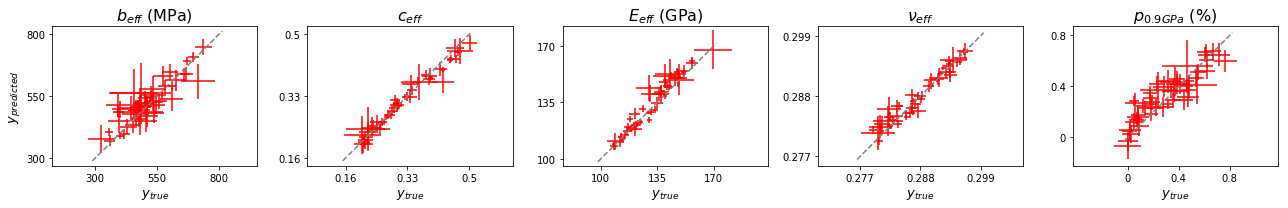

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power


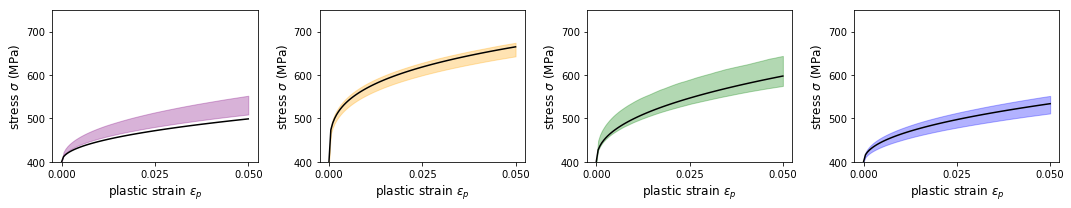

In [22]:
n = 25

alpha_list = 0.1 * np.random.rand(10)
random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)

regBBens_25 = ModelAveragingLOOalphaBB(
    nn_dict=nn_kwargs, training_data=(x_train_norm[:n], y_train_norm[:n]), 
    training_dict={'ns': 20, 'epochs': 12000, 'lr': 0.005},
    n_bootstrap=100, alpha_list=alpha_list, random_seed_list=random_seed_list)

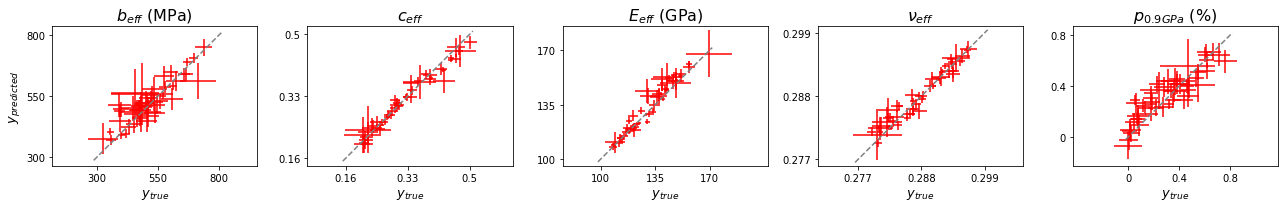

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power


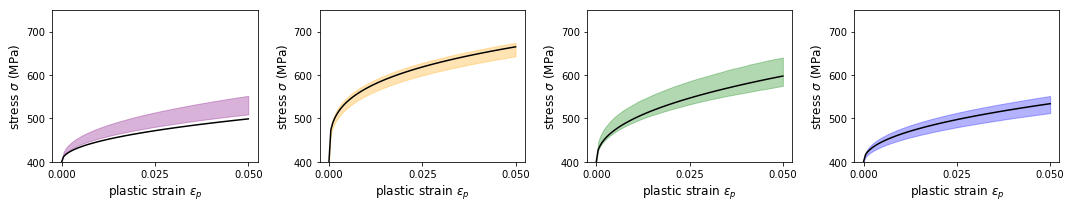

In [40]:
ypred, ystd, yMC = regBBens_25.predict_uq(X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), 
                                          return_MC=5000, aleatoric_in_std_perc=False, aleatoric_in_MC=False)

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
#fig.tight_layout()
#fig.savefig('PartA_25_crosses.pdf')
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
#fig.savefig('PartA_25_laws.pdf')
plt.show(fig)

Adding model with alpha=0.0488247774723947
Adding model with alpha=0.05415511682873558
Adding model with alpha=4.891210386959167e-06
Adding model with alpha=0.050499784148690066
Adding model with alpha=0.09150147515017944
Adding model with alpha=0.0431297849846398
Adding model with alpha=0.07714952270309634
Adding model with alpha=0.02432418153699503
Adding model with alpha=0.07675461643746362
Adding model with alpha=0.053535370555920364


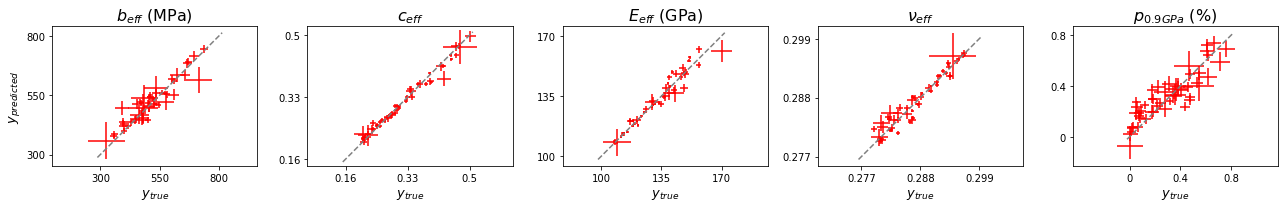

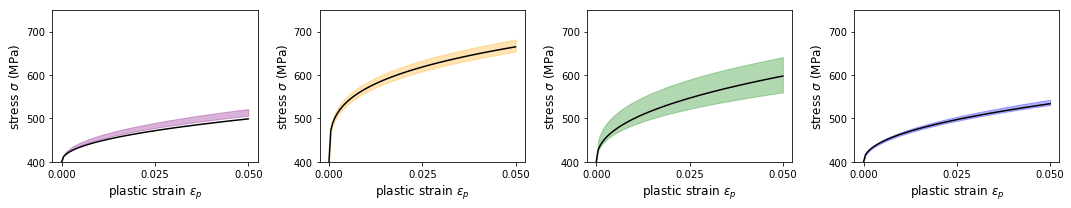

In [23]:
n = 50

alpha_list = 0.1 * np.random.rand(10)
random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)

regBBens_50 = ModelAveragingLOOalphaBB(
    nn_dict=nn_kwargs, training_data=(x_train_norm[:n], y_train_norm[:n]), 
    training_dict={'ns': 20, 'epochs': 12000, 'lr': 0.005},
    n_bootstrap=100, alpha_list=alpha_list, random_seed_list=random_seed_list)

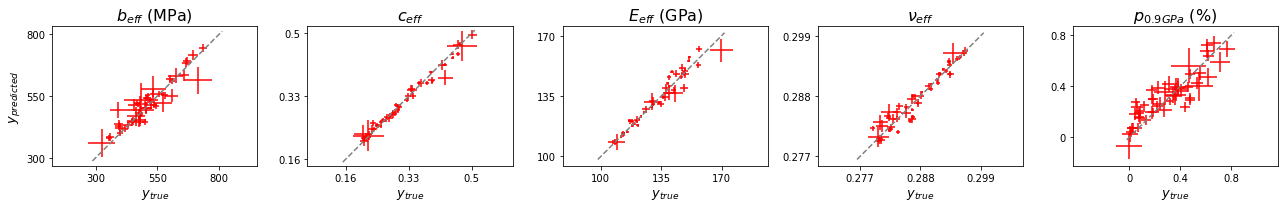

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power


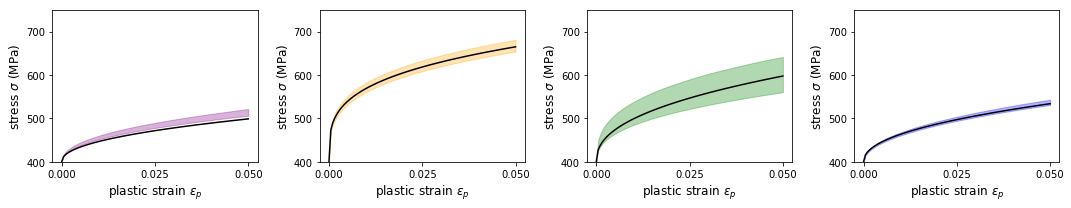

In [35]:
ypred, ystd, yMC = regBBens_50.predict_uq(X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), 
                                        return_MC=5000, aleatoric_in_std_perc=False, aleatoric_in_MC=False)

fig, ax = plot_ystd(y_test_norm, ypred, ystd)
fig.tight_layout()
#fig.savefig('PartA_50_crosses.pdf')
plt.show(fig)

yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5])
#fig.savefig('PartA_50_laws.pdf')
plt.show(fig)

## Look at aleatoric uncertainty for a couple of points

In [27]:
def plot_yMC_2d(ytest, yMC, indices_test, colors):
    fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(14, 13))
    
    for n, c in zip(indices_test, colors):
        for i in range(5):
            bds_i = bounds_outputs[i]
            for j in range(i+1, 5):
                bds_j = bounds_outputs[j]
                ax[i, j].scatter(x=yMC[:, n, j], y=yMC[:, n, i], alpha=0.05, color=c)
                ax[i, j].scatter(x=ytest[n, j], y=ytest[n, i], marker='s', color=c, edgecolors='black')
                if i == 0:
                    ax[i, j].set_xticks([bds_j[0], bds_j[1]])
                    ax[i, j].set_xticklabels(['{:.3g}'.format(val) for val in [bds_j[0], bds_j[1]]], fontsize=10)
                    ax[i, j].xaxis.tick_top()
                    ax[i, j].xaxis.set_label_position("top")
                    ax[i, j].set_xlabel(output_names[j], fontsize=15, labelpad=15)
                else:
                    ax[i, j].set_xticks([])
                if j == 4:
                    ax[i, j].set_yticks([bds_i[0], bds_i[1]])
                    ax[i, j].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], bds_i[1]]], fontsize=10)
                    ax[i, j].yaxis.tick_right()
                    ax[i, j].yaxis.set_label_position("right")
                    ax[i, j].set_ylabel(output_names[i], rotation=270, fontsize=15, labelpad=15)
                else:
                    ax[i, j].set_yticks([])
                ax[i, j].set_xlim([bds_j[0]-0.2*(bds_j[1]-bds_j[0]), bds_j[1]+0.2*(bds_j[1]-bds_j[0])])
                ax[i, j].set_ylim([bds_i[0]-0.2*(bds_i[1]-bds_i[0]), bds_i[1]+0.2*(bds_i[1]-bds_i[0])])
            for j in range(i+1):
                ax[i, j].axis('off')
    fig.tight_layout()
    return fig, ax

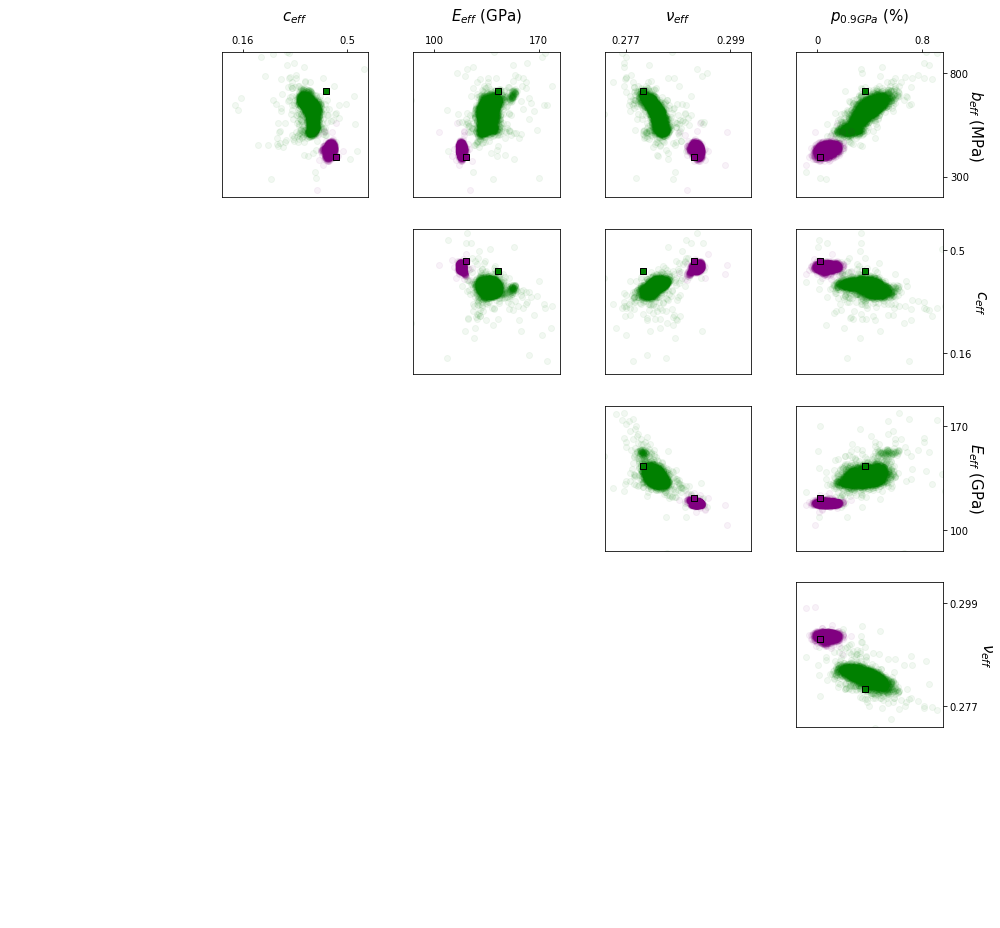

In [28]:
ypred, yMC = regBBens_50.predict_uq(X=x_test_norm, ns=10000, return_std=False, return_percentiles=(), 
                                    return_MC=5000, aleatoric_in_MC=False)
yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

fig, ax = plot_yMC_2d(y_test, yMC_, indices_test=[4, 0], colors=['green', 'purple'])
#fig.savefig('PartA_50_2Depistemic.pdf')
plt.show()

(50, 5)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)


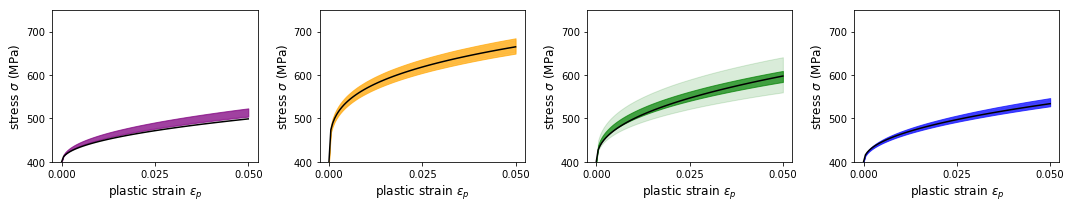

In [36]:
ypred, ystd, yMC = regBBens_50.predict_uq(X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), 
                                        return_MC=5000, aleatoric_in_std_perc=False, aleatoric_in_MC=False)

yMC_aleatoric = np.zeros_like(yMC_)
for i, mean in enumerate(ypred):
    yMC_aleatoric[:, i, :] = np.random.multivariate_normal(mean=mean, cov=cov_aleatoric_norm, size=yMC_.shape[0])
yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)
yMC_aleatoric_ = unnormalize_from_bounds(yMC_aleatoric, bounds_outputs, type_norm)
fig, ax = plot_law_MC(y_test, yMC_, indices_test=[0, 1, 4, 5], yMCaleatoric=yMC_aleatoric_)
#fig.savefig('PartA_50_laws_aleatoric.pdf')
plt.show()

In [38]:
def plot_ystd_total(ytest, ypred, ystd, outputs=(0, 1, 2, 3, 4)):
    fig, ax = plt.subplots(ncols=5, figsize=(20, 3))
    for i, (y_true, y_pm, y_ps) in enumerate(zip(ytest.T, ypred.T, ystd.T)):
        bds_i = bounds_outputs[i]
        ax[i].plot([-1.05, 1.05], [-1.05, 1.05], color='gray', linestyle='--')
        ax[i].errorbar(x=y_true, y=y_pm, yerr=y_ps, xerr=y_ps, color='red', linestyle='none', 
                           label='aleatoric uncertainty')
        ax[i].errorbar(x=y_true, y=y_pm, xerr=np.sqrt(cov_aleatoric_norm[i, i]+y_ps**2), 
                        yerr=np.sqrt(cov_aleatoric_norm[i, i]+y_ps**2), alpha=0.4, color='blue', 
                        linestyle='none', label='total uncertainty')
        ax[i].set_xticks([-1, 0, 1])
        ax[i].set_xticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
        ax[i].set_xlabel('$y_{true}$', fontsize=13)
        ax[i].set_yticks([-1, 0, 1])
        ax[i].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
        if i == 0:
            ax[i].set_ylabel('$y_{predicted}$', fontsize=13)
        ax[i].set_title(output_names[i], fontsize=16)
        ax[i].axis('equal')
    return fig, ax

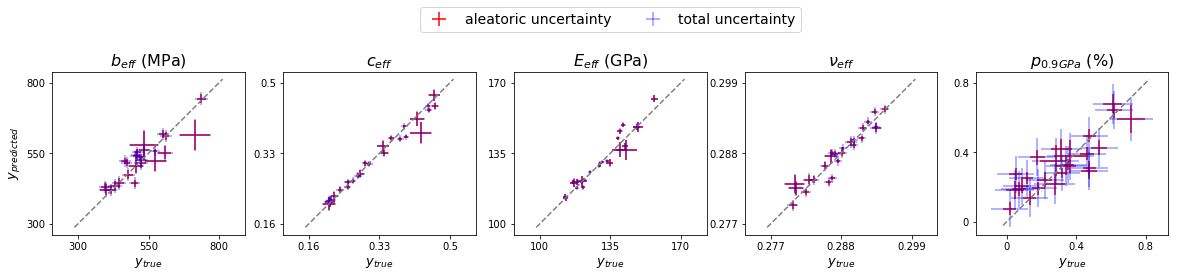

In [39]:
ypred, ystd = regBBens_50.predict_uq(X=x_test_norm, ns=5000, return_std=True, return_percentiles=(), 
                                     return_MC=0, aleatoric_in_std_perc=False, aleatoric_in_MC=False)

n=25
fig, ax = plot_ystd_total(y_test_norm[:n], ypred[:n], ystd[:n])
#fig.tight_layout()
lgd = ax[2].legend(loc='lower center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=14)
#fig.savefig('PartA_50_crosses_aleatoric.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)